In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (recall_score, f1_score, precision_score, mean_squared_error, accuracy_score, confusion_matrix)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     KFold, GridSearchCV)
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree
from sklearn.ensemble import (BaggingClassifier, GradientBoostingClassifier)
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
#Load in data
preg_df = pd.read_csv("Maternal Health Risk Data Set.csv", low_memory=False)

In [ ]:
#Look at dataframe to ensure everything looks good
preg_df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
count = (preg_df["RiskLevel"] == "high risk").sum()
count2 = (preg_df["RiskLevel"] == "mid risk").sum()
count3 = (preg_df["RiskLevel"] == "low risk").sum()
print("high risk = ", count) # 26.9%
print("mid risk = ", count2) # 33.1%
print("low risk = ", count3) # 40.0%

high risk =  272
mid risk =  336
low risk =  406


In [5]:
#Split the dataframe into X2_train, X2_test, y2_train, y2_test

X2 = preg_df.drop(columns=['RiskLevel'])
y2 = preg_df['RiskLevel']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [11]:
#Replace the classes (low risk, mid risk, and high risk) with 0,1, and 2, for ease of metric
# calculations (ex: precision)

y2_train = y2_train.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})
y2_test = y2_test.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})

<ipython-input-11-9dd454c05cc0>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y2_train = y2_train.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})
<ipython-input-11-9dd454c05cc0>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y2_test = y2_test.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})


In [ ]:
#Create a Benchmark Logistic Regression model, to asses whether or not their is a relationship
#between X and y

model2 = LogisticRegression(max_iter=10000)
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6502463054187192


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


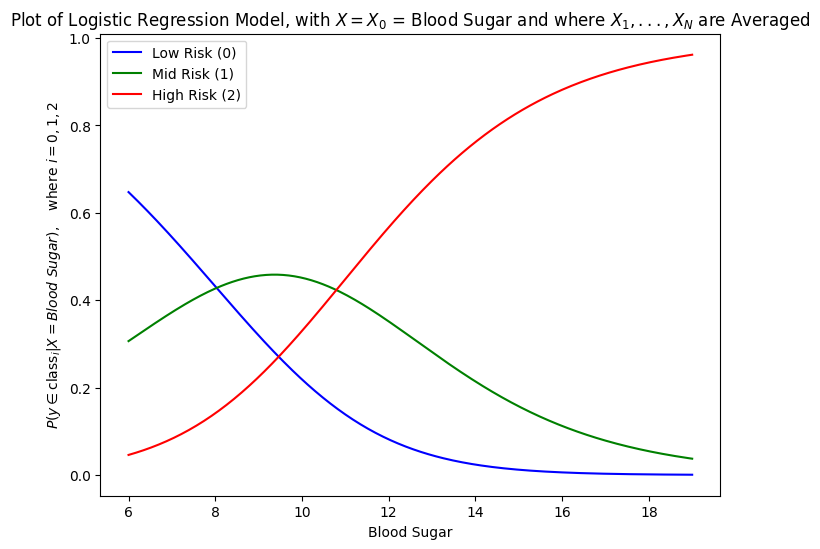

In [ ]:
#For LR visualization purposes ONLY!!! (Not actual model)

#We're selecting one predictor, Blood Sugar, and keeping the others constant (taking their average)
#This way, we can plot LR

feature_to_vary = 'BS'

diastolic_range = np.linspace(X2_test[feature_to_vary].min(), X2_test[feature_to_vary].max(), 300)

fixed_features = X2_test.mean(axis=0).to_numpy()
fixed_features = np.tile(fixed_features, (diastolic_range.shape[0], 1))

fixed_features[:, X2_test.columns.get_loc(feature_to_vary)] = diastolic_range

y_pred_proba = model2.predict_proba(fixed_features)

plt.figure(figsize=(8, 6))

plt.plot(diastolic_range, y_pred_proba[:, 0], color='blue', label="Low Risk (0)")
plt.plot(diastolic_range, y_pred_proba[:, 1], color='green', label="Mid Risk (1)")
plt.plot(diastolic_range, y_pred_proba[:, 2], color='red', label="High Risk (2)")


plt.xlabel('Blood Sugar')
plt.ylabel(r'$P(y \in \text{class}_i | X = Blood\ Sugar), \quad \text{where } i = 0, 1, 2$')
plt.title('Plot of Logistic Regression Model, with $X = X_{0}$ = Blood Sugar and where $X_{1},...,X_{N}$ are Averaged')
plt.legend()

plt.show()

In [ ]:
#Let's test PCA to see if our model will overfit. If the accuracy decreases, our model is prone to overfitting, which means we're dealing with a high variance-
#low bias model

pca2 = PCA(n_components=4)
X2_train_PCA = pca2.fit_transform(X2_train)
X2_test_PCA = pca2.fit_transform(X2_test)

model2.fit(X2_train_PCA, y2_train)
y2_pred = model2.predict(X2_test_PCA)

accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy}") #Got waayyyyyy worse

Accuracy: 0.5763546798029556


In [ ]:
#Let's test Ridge Regression as well. Penalizing our weights would help our classification accuracy if our model is overfit.

model2 = LogisticRegression(penalty = 'l2', max_iter=10000) #C = 0.01 made it worse, 0.1 made no difference
model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6502463054187192


In [ ]:
#And let's test Lasso Regression. Like PCA, reducing the dimensions of the dataset (eliminating unnecessary features) would make our model better if our dataset
#is prone high variance-low bias

L1model2 = LogisticRegression(penalty = 'l1', solver='liblinear', max_iter=10000) #C=0.01 makes it worse
L1model2.fit(X2_train, y2_train)

y2_pred = L1model2.predict(X2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.625615763546798


In [ ]:
#This is a tree depth finder. It prevents overfitting

param_grid = {
    'max_depth': range(1, 21)
}

tree_model = DTC(random_state=42)

kfold = KFold(n_splits=10, random_state=1, shuffle=True)

grid_search = GridSearchCV(estimator=tree_model,
                           param_grid=param_grid,
                           cv=kfold,
                           scoring='accuracy',
                           refit=True)

grid_search.fit(X2_train, y2_train)

best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_max_depth}")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X2_test, y2_test)
print(f"Test Accuracy: {test_accuracy}")

Best max_depth: 17
Test Accuracy: 0.8226600985221675


In [ ]:
#This is a maximum nodes finder. This also prevent overfitting

ccp_path = tree_model.cost_complexity_pruning_path(X2_train, y2_train)
ccp_alphas = ccp_path.ccp_alphas
kfold = KFold(10, random_state=1, shuffle=True)

grid = GridSearchCV(estimator=tree_model,
                        param_grid={'ccp_alpha': ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X2_train, y2_train)

best_ = grid.best_estimator_
print("Number of nodes in best tree = ", best_.tree_.node_count)

Number of nodes in best tree =  293


In [8]:
#Fit a tree with the max_depth!

tree_model = DTC(random_state=42, max_depth = 17)
tree_model.fit(X2_train, y2_train)
y_pred = tree_model.predict(X2_test)

accuracy = accuracy_score(y2_test, y_pred)
print(f"Accuracy: {accuracy}")

#This finds the most important features. Very helpful for interpretation
feature_names = X2.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance':tree_model.feature_importances_}, index = feature_names)
feature_imp.sort_values(by='importance', ascending=False)

Accuracy: 0.8226600985221675


,importance
BS,0.422242
SystolicBP,0.193785
Age,0.120829
HeartRate,0.109206
BodyTemp,0.077877
DiastolicBP,0.076062


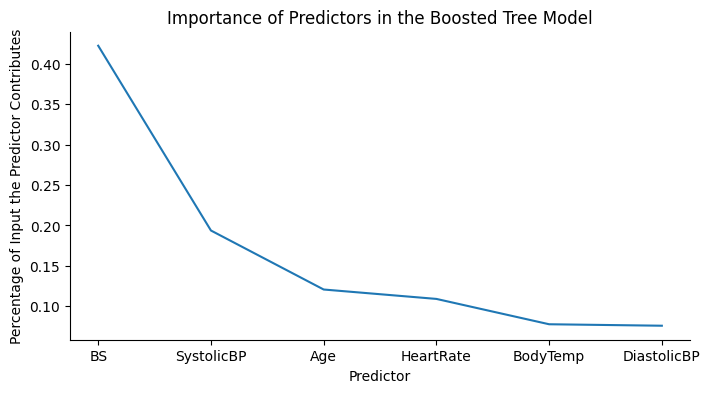

In [ ]:
#Plot the important features -- google colab wrote this chunk of code.

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='line', figsize=(8, 4), title = 'Importance of Predictors in the Boosted Tree Model')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.gca().set_xlabel('Predictor')
plt.gca().set_ylabel('Percentage of Input the Predictor Contributes')
plt.show()

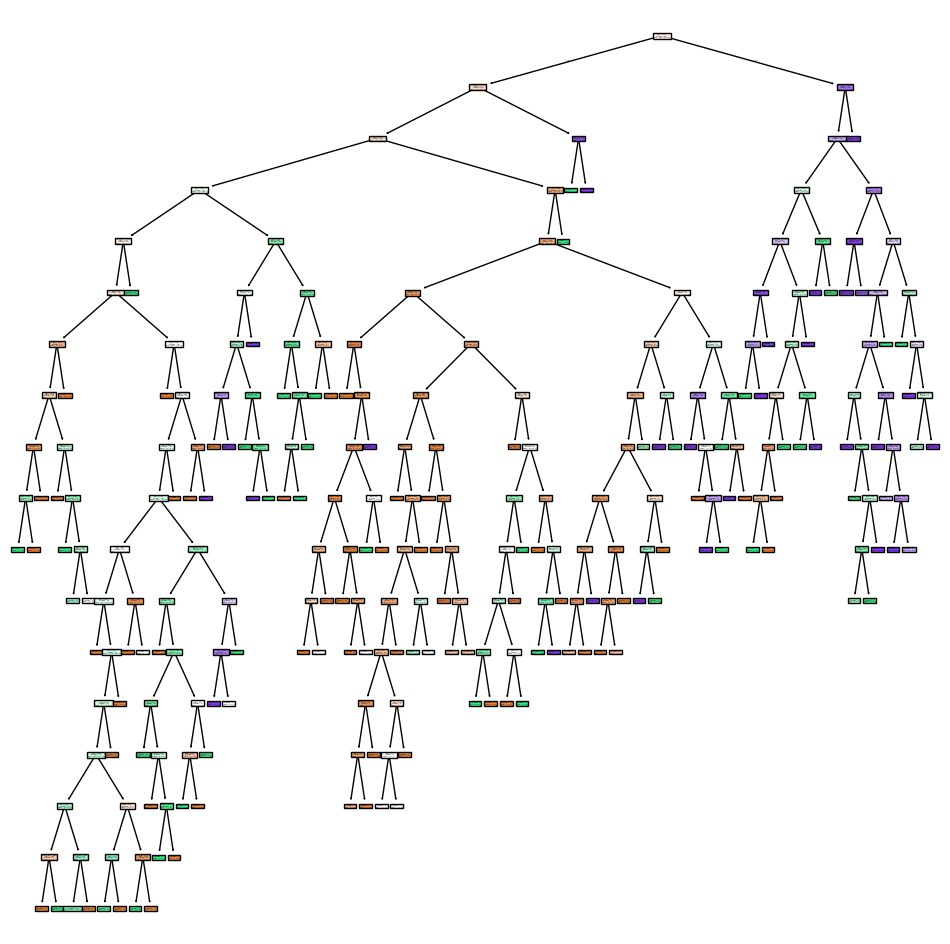

In [ ]:
#Let's visualize the tree!

ax = subplots(figsize=(12,12))[1]
plot_tree(tree_model, max_depth = 17, filled = True, feature_names = ('Age', 'SystolicBP',	'DiastolicBP', 'BS',	'BodyTemp',	'HeartRate',	'RiskLevel'),
          ax=ax);

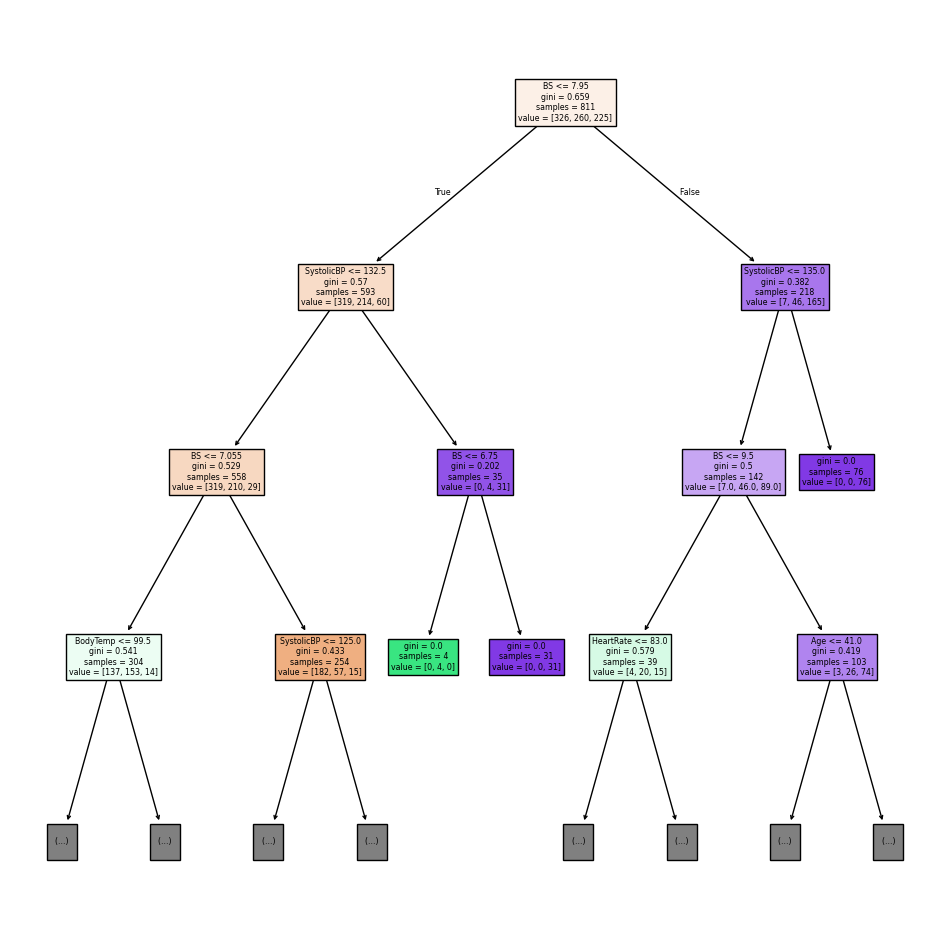

In [ ]:
#A zoom in on the tree to see what it's actually doing

ax = subplots(figsize=(12,12))[1]
plot_tree(tree_model, max_depth = 3, filled = True, feature_names = ('Age', 'SystolicBP',	'DiastolicBP', 'BS',	'BodyTemp',	'HeartRate',	'RiskLevel'),
          ax=ax);

In [9]:
#Now, let's create the baseline boost model ~ this model's hyperparameters have not been tuned

boost_model1 = GradientBoostingClassifier(n_estimators=1500, max_depth=17, learning_rate=0.1)

boost_model1.fit(X2_train, y2_train)
pred = boost_model1.predict(X2_test)

accuracy = accuracy_score(y2_test, pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8226600985221675


In [ ]:
#This is a custome Hyperparameter finder! Note that although an accuracy score of ~84% appears below, when the hyperparameters
#are plugged into the GradientBoostingClassifier, an accuracy score of ~83% is achieved

learn_rates = [0.001, 0.01, 0.1, 1]
estimators = [900, 1000, 1250, 1500, 1750, 2000]

purr = []

for i in learn_rates:
    for j in estimators:

        boost_model = GradientBoostingClassifier(n_estimators=j, max_depth=17, learning_rate=i)
        boost_model.fit(X2_train, y2_train)
        pred = boost_model.predict(X2_test)
        accuracy = accuracy_score(y2_test, pred)

        temp = [accuracy, j, i]
        purr.append(temp)

for result in purr:
    print(f"Accuracy: {result[0]}, Estimators: {result[1]}, Learning Rate: {result[2]}")

Accuracy: 0.812807881773399, Estimators: 900, Learning Rate: 0.001
Accuracy: 0.812807881773399, Estimators: 1000, Learning Rate: 0.001
Accuracy: 0.8177339901477833, Estimators: 1250, Learning Rate: 0.001
Accuracy: 0.8177339901477833, Estimators: 1500, Learning Rate: 0.001
Accuracy: 0.8177339901477833, Estimators: 1750, Learning Rate: 0.001
Accuracy: 0.8029556650246306, Estimators: 2000, Learning Rate: 0.001
Accuracy: 0.812807881773399, Estimators: 900, Learning Rate: 0.01
Accuracy: 0.8177339901477833, Estimators: 1000, Learning Rate: 0.01
Accuracy: 0.8325123152709359, Estimators: 1250, Learning Rate: 0.01
Accuracy: 0.8325123152709359, Estimators: 1500, Learning Rate: 0.01
Accuracy: 0.8325123152709359, Estimators: 1750, Learning Rate: 0.01
Accuracy: 0.8177339901477833, Estimators: 2000, Learning Rate: 0.01
Accuracy: 0.812807881773399, Estimators: 900, Learning Rate: 0.1
Accuracy: 0.8177339901477833, Estimators: 1000, Learning Rate: 0.1
Accuracy: 0.8275862068965517, Estimators: 1250, Lea

In [7]:
#Let's make another Boosted tree mode, but with the optimal hyperparameters

boost_model2 = GradientBoostingClassifier(n_estimators=1500, max_depth=17, learning_rate=0.01)

boost_model2.fit(X2_train, y2_train)
pred_boost_model2 = boost_model2.predict(X2_test)

accuracy = accuracy_score(y2_test, pred_boost_model2)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8325123152709359


In [6]:
#Perform K-Fold cross validation for the accuracy.
kf = KFold(n_splits= 10, shuffle= True, random_state=42)

scores = cross_val_score(estimator = boost_model2, X=X2, y = y2, scoring = 'accuracy', cv = kf)

print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())

Cross-validation scores: [0.81372549 0.81372549 0.82352941 0.89215686 0.84158416 0.87128713
 0.9009901  0.88118812 0.83168317 0.89108911]
Mean accuracy: 0.8560959037080179
Standard deviation of accuracy: 0.03295216412522703


In [ ]:
#Perform K-Fold cross validation for the precision.
kf = KFold(n_splits= 10, shuffle= True, random_state=42)

scores = cross_val_score(estimator = boost_model2, X=X2, y = y2, scoring = 'precision', cv = kf)

print("Cross-validation scores:", scores)
print("Mean precision:", scores.mean())
print("Standard deviation of precision:", scores.std())

Cross-validation scores: [0.81372549 0.81372549 0.83333333 0.89215686 0.84158416 0.87128713
 0.91089109 0.88118812 0.83168317 0.89108911]
Mean precision: 0.8580663948747815
Standard deviation of precision: 0.03356218800206466


In [13]:
#Perform K-Fold cross validation for the recall.
kf = KFold(n_splits= 10, shuffle= True, random_state=42)

scores = cross_val_score(estimator = boost_model2, X=X2, y = y2, scoring = 'recall_macro', cv = kf)

print("Cross-validation scores:", scores)
print("Mean recall:", scores.mean())
print("Standard deviation of recall:", scores.std())

Cross-validation scores: [0.82486772 0.81190476 0.83054483 0.89403324 0.87148077 0.87480799
 0.91615463 0.87222724 0.85150376 0.8983269 ]
Mean recall: 0.8645851834661981
Standard deviation of recall: 0.03249327281894223


In [14]:
#Let's look at the recall score for each class.
recall = recall_score(y2_test, pred_boost_model2, average=None)
print(f"Recall for each class: {recall}")

Recall for each class: [0.7875     0.86842105 0.85106383]


In [16]:
#Perform K-Fold cross validation for the F1 score.
kf = KFold(n_splits= 10, shuffle= True, random_state=42)

scores = cross_val_score(estimator = boost_model2, X=X2, y = y2, scoring = 'f1_macro', cv = kf)

print("Cross-validation scores:", scores)
print("Mean F1:", scores.mean())
print("Standard deviation of F1:", scores.std())

Cross-validation scores: [0.81551657 0.81936067 0.83903904 0.89301444 0.84108828 0.87847287
 0.90245631 0.87071407 0.83813747 0.89301363]
Mean F1: 0.8590813367140748
Standard deviation of F1: 0.030553733223187836


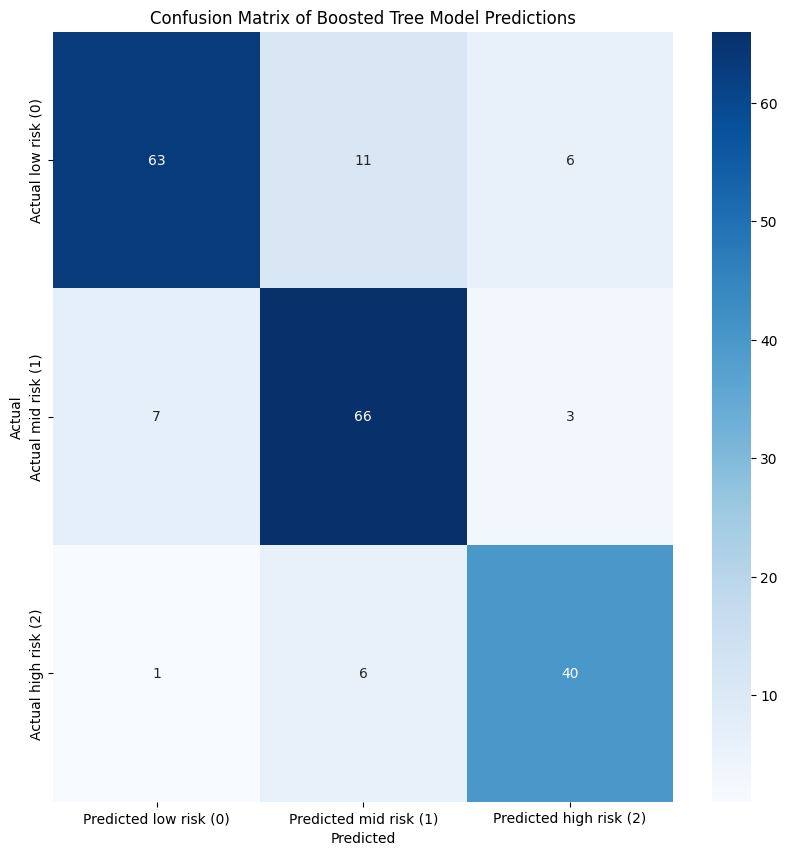

In [ ]:
#This is a confusion matrix to help us visualize how well our model is performing.

cm = confusion_matrix(y2_test, pred_boost_model2)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted low risk (0)', 'Predicted mid risk (1)', 'Predicted high risk (2)'], yticklabels=['Actual low risk (0)', 'Actual mid risk (1)', 'Actual high risk (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Boosted Tree Model Predictions')
plt.show()